# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

We will explore the given three data sets in this section

In [2]:
print("Portfolio/Offers data dimensions: Rows: {} , Columns: {}".format(portfolio.shape[0], portfolio.shape[1]))

Portfolio/Offers data dimensions: Rows: 10 , Columns: 6


In [3]:
print("Profile/Customer data dimensions: Rows: {} , Columns: {}".format(profile.shape[0],profile.shape[1]))

Profile/Customer data dimensions: Rows: 17000 , Columns: 5


In [4]:
print("Transcript data dimensions: Rows: {} , Columns: {}".format(transcript.shape[0],transcript.shape[1]))

Transcript data dimensions: Rows: 306534 , Columns: 4


Let's take a look at sample records from each dataset

### Offers data

As there are only 10 records in offers dataset, let's look at all the 10 records

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


By looking at the data returned from info() method, all the 10 records have values and no missing data. There are 3 types of offers i.e.; bogo, discount, informational.
As the reward column is having 0 value for both informational offers, we can delete these two offers from the dataset as customers might not be interested in these kind of offers

### Customers Data

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


From the above metrics, we can see that there are missing values in profile dataset. Out of total 17000 records, income and gender is present for only 14825 records and remaining have null values.So, while doing data processing, we can remove the records which have missing data points.

In [10]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

There are three gender unique values present. Male, Female and Other

### Transcript Data

In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


All records have all the data elements in the transcript dataset.

In [14]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 4 events in the data set namely, transction, offer recieved, offer viewed, offer completed and distribution is also showed in below histrogram across 4 events

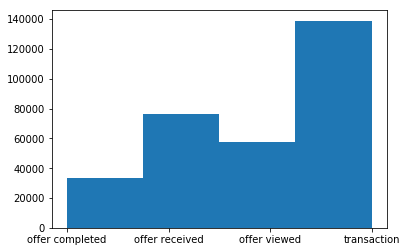

In [15]:
plt.hist(transcript['event'],bins = 4)
plt.show()

As we have explored all the given data sets, lets proceed with Data Cleansing step

## Data Cleansing and preprocessing

We will copy the given datasets to new dataframes to preserve actial datasets

In [16]:
portfolio_cp = portfolio.copy()
profile_cp = profile.copy()
transcript_cp = transcript.copy()

Now, we will do data cleaning for each dataset.

First, lets remove the records from portfolio where offer type is 'informational'.

In [17]:
portfolio_cp = portfolio_cp[portfolio_cp['offer_type'] != 'informational']

In [18]:
portfolio_cp

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Now, remove the records from profile dataset where gender value is 'O' and records where null values exists

In [19]:
profile_cp = profile_cp[profile_cp['gender'] != 'O']

After removing rows with gender as 'O' value, lets see the distribution

In [20]:
profile_cp.gender.value_counts()

M    8484
F    6129
Name: gender, dtype: int64

We will remove the records where income is not specified

In [22]:
profile_cp.dropna(inplace=True)

In [23]:
profile_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 5 columns):
age                 14613 non-null int64
became_member_on    14613 non-null int64
gender              14613 non-null object
id                  14613 non-null object
income              14613 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 685.0+ KB


All the records with null values are removed and all records have values.

We have the column 'became_member_on' with date specified on when the customer became rewards member.As the value is not in the proper format,we will transform to year and number of days since customer joined rewards program

In [24]:
profile_cp['year'] = pd.DatetimeIndex(profile_cp[['became_member_on']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))['became_member_on']).year

In [25]:

profile_cp['membership_age'] = (pd.to_datetime('today').floor('D') - pd.to_datetime(profile_cp[['became_member_on']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))['became_member_on'])).dt.days

In [26]:
profile_cp.head()

,age,became_member_on,gender,id,income,year,membership_age
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1132
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1199
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,847
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,923
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1013


In [27]:
profile_cp.reset_index(inplace=True)

We will see the data distribution now over age, income and joined year

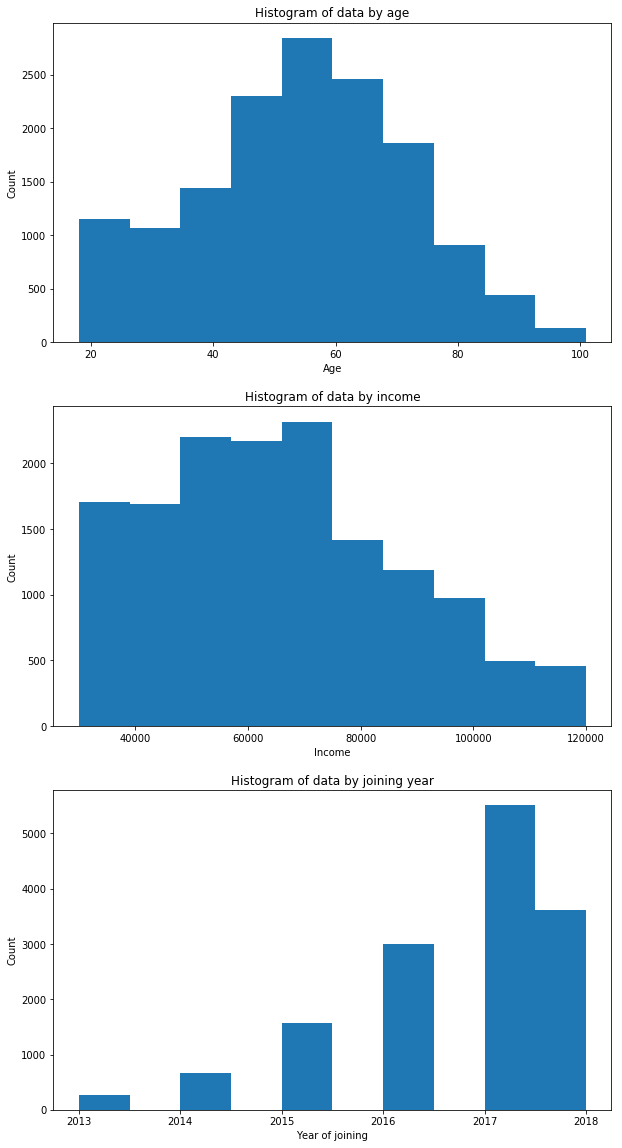

In [28]:
fig, ax = plt.subplots(3, figsize=(10,20))
ax[0].hist(profile_cp['age'])
ax[0].set(xlabel = 'Age', ylabel = 'Count', title = 'Histogram of data by age')
ax[1].hist(profile_cp['income'])
ax[1].set(xlabel = 'Income', ylabel = 'Count', title = 'Histogram of data by income')
ax[2].hist(profile_cp['year'])
ax[2].set(xlabel = 'Year of joining', ylabel = 'Count', title = 'Histogram of data by joining year')
plt.show()

As we are done with data cleaning now for all the datasets, we will do preprocessing of data to classify the customers.

### Preprocessing of data

Our goal is to classify customers into two classes. First class is to customers for whom offers to be sent and second class is to whom offers should not be sent.

To achieve this goal, we will consider demographic information of customers like amount spent, age, income etc.

First, we will fetch offer id from each 'value' field if exists

In [29]:
 transcript_cp_offers = transcript_cp[transcript_cp['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

In [30]:
transcript_cp_offers['offerid'] = transcript_cp_offers['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
transcript_cp_offers.head()

,event,person,time,value,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


Now, we have to get amount spent by each customer

In [32]:
transcript_cp_amt = transcript_cp[transcript_cp['event'] == 'transaction']

In [33]:
transcript_cp_amt.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [34]:
transcript_cp_amt['amount'] = transcript_cp_amt['value'].apply(lambda x: x['amount'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


As, we have derived the amount for ech transaction, we can remove 'value' field from the data set.

In [35]:
transcript_cp_amt.drop(['value'],axis = 1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
transcript_cp_amt.head()

,event,person,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [37]:
transcript_cp_amt.groupby('person').size()

person
0009655768c64bdeb2e877511632db8f     8
00116118485d4dfda04fdbaba9a87b5c     3
0011e0d4e6b944f998e987f904e8c1e5     5
0020c2b971eb4e9188eac86d93036a77     8
0020ccbbb6d84e358d3414a3ff76cffd    12
003d66b6608740288d6cc97a6903f4f0    18
00426fe3ffde4c6b9cb9ad6d077a13ea    17
004b041fbfe44859945daa2c7f79ee64     6
004c5799adbf42868b9cff0396190900    12
005500a7188546ff8a767329a2f7c76a     4
0056df74b63b4298809f0b375a304cf4     5
0063def0f9c14bc4805322a488839b32     3
0069a50874d846438e58acff5e594725     5
00715b6e55c3431cb56ff7307eb19675    15
0082fd87c18f45f2be70dbcbb0fb8aad     7
00840a2ca5d2408e982d56544dc14ffd    17
00857b24b13f4fe0ad17b605f00357f5     4
008d7088107b468893889da0ede0df5c     7
0091d2b6a5ea4defaa8393e4e816db60    12
0092a132ead946ceb30d11a1ed513d20     3
0099bf30e4cb4265875266eb3eb25eab     9
009d10c2c38a4fd795a7bc6ddbbddb78     7
00a794f62b9a48beb58f8f6c02c2f1a6    11
00ad4c2cace94f67a6354ec90d6c6f45     8
00ae03011f9f49b8a4b3e6d416678b0b     8
00aee28bbb3848dd8a

We can get total amount spent by each customer using the transction records.

In [38]:
transcript_cp_amt = pd.DataFrame(transcript_cp_amt.groupby('person')['amount'].sum())

In [39]:
transcript_cp_amt.head()

,amount
person,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05


As we got the total amount of money spend by each customer, let's get the stats about offers for each person

In [40]:
transcript_cp_offers.head()

,event,person,time,value,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
transcript_cp_offers.drop('time', axis = 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Now, merge the transcript offers data wiht offers data to get offers types

In [42]:
transcript_cp_offers = pd.merge(transcript_cp_offers, portfolio_cp,left_on = 'offerid', right_on = 'id')

In [43]:
transcript_cp_offers.head()

,event,person,value,offerid,channels,difficulty,duration,id,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5


Drop the columns which are not required in this analysis

In [44]:
transcript_cp_offers = transcript_cp_offers.drop(['duration','reward','id','difficulty'],axis = 1)


In [46]:
transcript_cp_offers.columns

Index(['event', 'person', 'value', 'offerid', 'channels', 'offer_type'], dtype='object')

Now, we will see how each person did on offer types and event types

In [47]:
person_offers = transcript_cp_offers.groupby(['person','offer_type']).size().reset_index(name='value').pivot(index='person',columns='offer_type',values = 'value')

In [48]:
transcript_cp = transcript_cp.drop(['time'], axis = 1)

In [49]:
person_events = transcript_cp_offers.groupby(['person','event']).size().reset_index(name='maxvalue').pivot(index='person',columns='event',values='maxvalue')

We will merge three datasets to acheive the dataset where we have data for each customer on how much money customer spent, how many events they recieved, viewed and completed

In [50]:
person = pd.concat([person_offers,person_events],axis = 1,join = 'inner' )

In [51]:
person = person.merge(transcript_cp_amt,on='person',how ='inner')

In [52]:
person.shape

(16510, 6)

In [53]:
person.head()

,bogo,discount,offer completed,offer received,offer viewed,amount
person,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,3.0,3.0,2.0,127.60
00116118485d4dfda04fdbaba9a87b5c,4.0,NaN,NaN,2.0,2.0,4.09
0011e0d4e6b944f998e987f904e8c1e5,3.0,6.0,3.0,3.0,3.0,79.46
0020c2b971eb4e9188eac86d93036a77,4.0,5.0,3.0,4.0,2.0,196.86
0020ccbbb6d84e358d3414a3ff76cffd,6.0,3.0,3.0,3.0,3.0,154.05


In [ ]:
portfolio_cp = portfolio_cp.drop(['difficulty'], axis = 1)

In [54]:
profile_cp.head()

,index,age,became_member_on,gender,id,income,year,membership_age
0,1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1132
1,3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1199
2,5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,847
3,8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,923
4,12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1013


Change the index of profile_cp dataset with person id

In [55]:
profile_cp = profile_cp.set_index('id')

In [56]:
profile_cp.head()

,index,age,became_member_on,gender,income,year,membership_age
id,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,55,20170715,F,112000.0,2017,1132
78afa995795e4d85b5d9ceeca43f5fef,3,75,20170509,F,100000.0,2017,1199
e2127556f4f64592b11af22de27a7932,5,68,20180426,M,70000.0,2018,847
389bc3fa690240e798340f5a15918d5c,8,65,20180209,M,53000.0,2018,923
2eeac8d8feae4a8cad5a6af0499a211d,12,58,20171111,M,51000.0,2017,1013


In [57]:
profile_cp.rename_axis("person", inplace=True)

In [58]:
profile_cp = profile_cp.drop(['became_member_on','index'], axis = 1)
profile_cp.head()

,age,gender,income,year,membership_age
person,,,,,
0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017,1132
78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017,1199
e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018,847
389bc3fa690240e798340f5a15918d5c,65,M,53000.0,2018,923
2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,2017,1013


In [59]:
person = person.merge(profile_cp,on='person',how ='inner')

In [60]:
person.head()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,gender,income,year,membership_age
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,3.0,3.0,2.0,127.60,33,M,72000.0,2017,1217
0020c2b971eb4e9188eac86d93036a77,4.0,5.0,3.0,4.0,2.0,196.86,59,F,90000.0,2016,1630
0020ccbbb6d84e358d3414a3ff76cffd,6.0,3.0,3.0,3.0,3.0,154.05,24,F,60000.0,2016,1378
003d66b6608740288d6cc97a6903f4f0,NaN,8.0,3.0,3.0,2.0,48.34,26,F,73000.0,2017,1156
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,6.0,1.0,4.0,1.0,68.51,19,F,65000.0,2016,1472


In [61]:
person.drop(['year'], axis = 1, inplace =True)

In [62]:
person.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14231 entries, 0009655768c64bdeb2e877511632db8f to ffff82501cea40309d5fdd7edcca4a07
Data columns (total 10 columns):
bogo               12619 non-null float64
discount           12561 non-null float64
offer completed    11807 non-null float64
offer received     14231 non-null float64
offer viewed       13889 non-null float64
amount             14231 non-null float64
age                14231 non-null int64
gender             14231 non-null object
income             14231 non-null float64
membership_age     14231 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 1.2+ MB


In [63]:
person.describe()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age
count,12619.000000,12561.000000,11807.000000,14231.000000,13889.000000,14231.000000,14231.000000,14231.000000,14231.000000
mean,4.905935,4.802882,2.705429,3.605439,2.806898,119.783824,54.309184,65262.455203,1285.552245
std,2.580290,2.607863,1.301281,1.177725,1.174570,130.565478,17.449785,21641.386150,420.474708
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.150000,18.000000,30000.000000,756.000000
25%,3.000000,3.000000,2.000000,3.000000,2.000000,34.105000,42.000000,49000.000000,968.000000
50%,5.000000,4.000000,3.000000,4.000000,3.000000,89.940000,55.000000,63000.000000,1119.000000
75%,6.000000,6.000000,4.000000,4.000000,4.000000,162.725000,66.000000,79000.000000,1562.000000
max,18.000000,17.000000,6.000000,6.000000,6.000000,1608.690000,101.000000,120000.000000,2579.000000


Let's see if the dataset has any Null values or not

In [64]:
person.isna().sum()

bogo               1612
discount           1670
offer completed    2424
offer received        0
offer viewed        342
amount                0
age                   0
gender                0
income                0
membership_age        0
dtype: int64

As there are null values in the dataset, we need to replace the null values with '0'. This is to avoid model training problems with null values.

In [65]:
person.fillna(0, inplace=True)

In [66]:
person.isna().sum()

bogo               0
discount           0
offer completed    0
offer received     0
offer viewed       0
amount             0
age                0
gender             0
income             0
membership_age     0
dtype: int64

In [67]:
person.head()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,gender,income,membership_age
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,3.0,3.0,2.0,127.60,33,M,72000.0,1217
0020c2b971eb4e9188eac86d93036a77,4.0,5.0,3.0,4.0,2.0,196.86,59,F,90000.0,1630
0020ccbbb6d84e358d3414a3ff76cffd,6.0,3.0,3.0,3.0,3.0,154.05,24,F,60000.0,1378
003d66b6608740288d6cc97a6903f4f0,0.0,8.0,3.0,3.0,2.0,48.34,26,F,73000.0,1156
00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,6.0,1.0,4.0,1.0,68.51,19,F,65000.0,1472


### One-hot encoding

We will use on-hot enconding process for each customer on 'gender' field. Person who is 'Male' will recieve '1' in 'M' field and '0' for 'F' field and vice-versa.

In [68]:
customer = pd.concat([person,pd.get_dummies(person['gender'])],axis=1).drop(['gender'],axis=1)

In [69]:
customer.describe()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age,F,M
count,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000
mean,4.350221,4.239266,2.244607,3.605439,2.739442,119.783824,54.309184,65262.455203,1285.552245,0.419366,0.580634
std,2.884671,2.896945,1.561832,1.177725,1.237442,130.565478,17.449785,21641.386150,420.474708,0.493473,0.493473
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.150000,18.000000,30000.000000,756.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,2.000000,34.105000,42.000000,49000.000000,968.000000,0.000000,0.000000
50%,4.000000,4.000000,2.000000,4.000000,3.000000,89.940000,55.000000,63000.000000,1119.000000,0.000000,1.000000
75%,6.000000,6.000000,3.000000,4.000000,4.000000,162.725000,66.000000,79000.000000,1562.000000,1.000000,1.000000
max,18.000000,17.000000,6.000000,6.000000,6.000000,1608.690000,101.000000,120000.000000,2579.000000,1.000000,1.000000


As we can see, all the features are in varied ranges like amount, income is high numbers and age is with 18 to 101.
This may results in giving more importance to featues with high numbers. So, we need to normalize the values of the features.

### Normalization of values

We will use MinMaxScaler() to normalize the values

In [70]:
# Defining the MinMaxScaler
scaler = MinMaxScaler()

In [71]:
# Selecting columns to be scaled with values 0 to 1
columns_toscale = ['income','membership_age','bogo','discount','offer completed','offer received','offer viewed','amount']

In [72]:
customer[columns_toscale] = scaler.fit_transform(customer[columns_toscale])

In [73]:
customer.head()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age,F,M
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.166667,0.294118,0.500000,0.4,0.333333,0.079233,33,0.466667,0.252880,0,1
0020c2b971eb4e9188eac86d93036a77,0.222222,0.294118,0.500000,0.6,0.333333,0.122291,59,0.666667,0.479430,1,0
0020ccbbb6d84e358d3414a3ff76cffd,0.333333,0.176471,0.500000,0.4,0.500000,0.095677,24,0.333333,0.341196,1,0
003d66b6608740288d6cc97a6903f4f0,0.000000,0.470588,0.500000,0.4,0.333333,0.029959,26,0.477778,0.219419,1,0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.000000,0.352941,0.166667,0.6,0.166667,0.042498,19,0.388889,0.392759,1,0


As of now, all the columns are scaled between 0 and 1 except customer age colum. We would like to scaling in inverse way for age.
We would like to assign high normalized value to customers with less age and less normalized value with poeple of more age

In [74]:
min_value = customer['age'].min()
max_value = customer['age'].max()
print(min_value)
print(max_value)

18
101


In [75]:
customer['age'] = customer['age'].apply(lambda x : (x - max_value)/(min_value-max_value) )

In [76]:
customer.describe()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age,F,M
count,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000,14231.000000
mean,0.241679,0.249369,0.374101,0.521088,0.456574,0.074374,0.562540,0.391805,0.290484,0.419366,0.580634
std,0.160260,0.170409,0.260305,0.235545,0.206240,0.081170,0.210238,0.240460,0.230650,0.493473,0.493473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.117647,0.166667,0.400000,0.333333,0.021109,0.421687,0.211111,0.116292,0.000000,0.000000
50%,0.222222,0.235294,0.333333,0.600000,0.500000,0.055821,0.554217,0.366667,0.199122,0.000000,1.000000
75%,0.333333,0.352941,0.500000,0.600000,0.666667,0.101070,0.710843,0.544444,0.442128,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have scaled all the attributes to between 0 and 1 values

In [77]:
# Saving the cutomer data for future use
customer.to_pickle("./customer.pkl")

In order to classify customers, we will calculate probabilities for each customer for sending offers in order to lure customers to spend more in the stores.

For that, we will assign different weights to each feature

In [78]:
customer['probab'] = 0.05*customer['bogo'] + 0.05*customer['discount'] + 0.05*customer['F'] + 0.05*customer['M'] + 0.25*customer['amount'] + 0.15*customer['income'] + 0.10*customer['age'] + 0.05*customer['membership_age'] + 0.10*customer['offer completed'] + 0.10*customer['offer viewed'] + 0.05*customer['offer received']

In [79]:
customer.head()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age,F,M,probab
person,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.166667,0.294118,0.500000,0.4,0.333333,0.079233,0.819277,0.466667,0.252880,0,1,0.360753
0020c2b971eb4e9188eac86d93036a77,0.222222,0.294118,0.500000,0.6,0.333333,0.122291,0.506024,0.666667,0.479430,1,0,0.394297
0020ccbbb6d84e358d3414a3ff76cffd,0.333333,0.176471,0.500000,0.4,0.500000,0.095677,0.927711,0.333333,0.341196,1,0,0.379240
003d66b6608740288d6cc97a6903f4f0,0.000000,0.470588,0.500000,0.4,0.333333,0.029959,0.903614,0.477778,0.219419,1,0,0.357351
00426fe3ffde4c6b9cb9ad6d077a13ea,0.000000,0.352941,0.166667,0.6,0.166667,0.042498,0.987952,0.388889,0.392759,1,0,0.318371


(array([  138.,  1166.,  2832.,  3701.,  3287.,  2019.,   847.,   198.,
           30.,    13.]),
 array([ 0.09980758,  0.1596965 ,  0.21958541,  0.27947432,  0.33936324,
         0.39925215,  0.45914107,  0.51902998,  0.5789189 ,  0.63880781,
         0.69869673]),
 <a list of 10 Patch objects>)

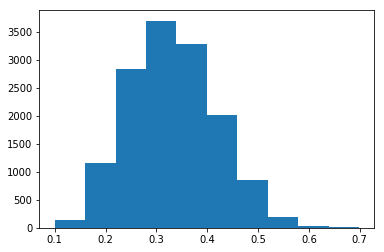

In [80]:
plt.hist(customer['probab'])

As we can see from above histogram, more customers are within 0.3 to 0.4 range. So, we will tweak probabilities to align customers 

In [93]:
customer['probab'] = 0.05*customer['bogo'] + 0.05*customer['discount'] + 0.05*customer['F'] + 0.05*customer['M'] + 0.10*customer['amount'] + 0.25*customer['income'] + 0.10*customer['age'] + 0.10*customer['membership_age'] + 0.10*customer['offer completed'] + 0.10*customer['offer viewed'] + 0.10*customer['offer received']

(array([   69.,   561.,  1650.,  2829.,  3109.,  2888.,  1858.,   963.,
          253.,    51.]),
 array([ 0.10575112,  0.1686391 ,  0.23152708,  0.29441507,  0.35730305,
         0.42019103,  0.48307901,  0.54596699,  0.60885498,  0.67174296,
         0.73463094]),
 <a list of 10 Patch objects>)

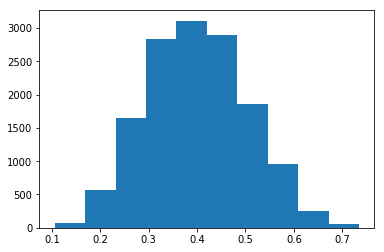

In [94]:
plt.hist(customer['probab'])

In [96]:
customer[customer['probab'] >= 0.30].shape

(11741, 12)

In [97]:
customer[customer['probab'] >= 0.60].shape

(382, 12)

In [98]:
customer['target'] = customer['probab'].apply(lambda x: 1 if (x >=0.30 and x<=0.60) else 0)

(array([  2872.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  11359.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

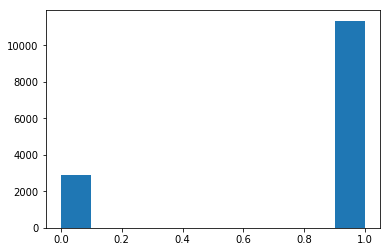

In [99]:
plt.hist(customer['target'])

In [100]:
customer.to_pickle("./processed_customer_data.pkl")

## Split the data into train and test sets

We will split the data in 75%-25% ratio where 75% of data samples will be used for model training and 25% samples will be used for validation of the model.

Before splitting the data for model training, lets define the features and target label.

In [101]:
model_features, model_label = customer.iloc[:,:-2] , customer.iloc[:,-1]

Let's look at the features data

In [102]:
model_features.head()

,bogo,discount,offer completed,offer received,offer viewed,amount,age,income,membership_age,F,M
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.166667,0.294118,0.500000,0.4,0.333333,0.079233,0.819277,0.466667,0.252880,0,1
0020c2b971eb4e9188eac86d93036a77,0.222222,0.294118,0.500000,0.6,0.333333,0.122291,0.506024,0.666667,0.479430,1,0
0020ccbbb6d84e358d3414a3ff76cffd,0.333333,0.176471,0.500000,0.4,0.500000,0.095677,0.927711,0.333333,0.341196,1,0
003d66b6608740288d6cc97a6903f4f0,0.000000,0.470588,0.500000,0.4,0.333333,0.029959,0.903614,0.477778,0.219419,1,0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.000000,0.352941,0.166667,0.6,0.166667,0.042498,0.987952,0.388889,0.392759,1,0


Let's take a look at the taergt label data

In [103]:
model_label.head()

person
0009655768c64bdeb2e877511632db8f    1
0020c2b971eb4e9188eac86d93036a77    1
0020ccbbb6d84e358d3414a3ff76cffd    1
003d66b6608740288d6cc97a6903f4f0    1
00426fe3ffde4c6b9cb9ad6d077a13ea    1
Name: target, dtype: int64

As mentioned earlier, now we need tp split data samples to training set and test set. This is very important to make sure our model is giving desired results on unseen data.

In [104]:
train_X, test_X,train_y, test_y = train_test_split(model_features, model_label, train_size =0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Benchmark model

We are using logistic regression as benchmark model. Out goal is to establish model metrics  with Logistic model and will choose a different model to achieve better results which can be used in Production

In [105]:
# Define the Logistic model
logmod = LogisticRegression(random_state=0)

In [106]:
#Train the Logistic Regression model
%time
logmod.fit(train_X, train_y)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

As the model is trained, lets do the prediction of target label on test set.

In [107]:
#Predicting the target value using Logistic Regression model
%time
test_y_preds = logmod.predict(test_X)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


Now, the prediction is also completed using Logistic model, let's take a look at various metrics for this model to see how well it is performed on test set.

In [109]:
print("Accuracy score of Logistic Regression model: {}".format(accuracy_score(test_y_preds,test_y) * 100))

Accuracy score of Logistic Regression model: 91.03428892636313


We will also see the confusion matrix for the model

In [112]:
confusion_matrix(test_y, test_y_preds)

array([[ 404,  313],
       [   6, 2835]])

In [113]:
# Calculating TP, FP, TN, FN values for the Logistic model
ltn, lfp, lfn, ltp = confusion_matrix(test_y, test_y_preds).ravel()

In [114]:
print("True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}".format(ltn,lfp,lfn,ltp))

True Negative: 404, False Positive: 313, False Negative: 6, True Positive: 2835


## Actual Model

In [115]:
rfc = RandomForestClassifier(max_depth=25,random_state = 0, n_estimators=10)

Now, we have to train the model using training dataset using Random Forest Classifier

In [116]:
# Training the Random Forest Classifier(RFC) model
%time
rfc.fit(train_X,train_y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

We will see how Random Forest method has trained the model and which input features are given high importance

In [117]:
pd.DataFrame({'col_name': rfc.feature_importances_}, index=model_features.columns).sort_values(by='col_name', ascending=False)

,col_name
income,0.241157
offer completed,0.141621
amount,0.131580
membership_age,0.109809
offer received,0.100352
age,0.096022
offer viewed,0.075781
bogo,0.047512
discount,0.043760
F,0.006533


In [118]:
# Predicting the test set using RFC
%time
rfc_test_y_preds = rfc.predict(test_X)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


Now, let's verify the accuracy and precision metrics of Random Forest Classifier model

In [120]:
print("Accuracy score of Random Forest Classifier model: {}".format(accuracy_score(rfc_test_y_preds,test_y) * 100))

Accuracy score of Random Forest Classifier model: 94.68802698145026


In [121]:
print("Precision score of Random Forest Classifier model: {}".format(precision_score(rfc_test_y_preds,test_y) * 100))

Precision score of Random Forest Classifier model: 97.60647659274903


### Confusion Matrix for Random Forest Classifier model

In [122]:
confusion_matrix(test_y, rfc_test_y_preds)

array([[ 596,  121],
       [  68, 2773]])

In [123]:
# Calculating TP, FP, TN, FN values for the Random Forest Classifier model
rtn, rfp, rfn, rtp = confusion_matrix(test_y, rfc_test_y_preds).ravel()
print("True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}".format(rtn,rfp,rfn,rtp))

True Negative: 596, False Positive: 121, False Negative: 68, True Positive: 2773


## Conclusion

Our goal is to classify customers into two classes 

    1.Class of customers where offers to be sent (Class Label : 1)
    2.Class of customers where offers need not to be sent (Class Label :0 )
    
 We have used given 3 data sets of users to get each customer statistics like how much amount customer spent and what kind of offers received and completed.
 
 After classifying customers based on their demographics information, we used Logit model to set benchmark for the classification.
 With logistic model, we see a <b>91% </b> accuracy of predicting the test dataset.
 
 To improve the accuracy metric, we used Random Forest Classifier model which is an ensemble model to improve the scores and we achived <b>94%</b> accuracy with predictions on the test dataset.
 
 So, with Random Forest Classifier model, we can use any future data sets to determine to whom Starbucks needs to send offers to acheive more revenue.